<a href="https://colab.research.google.com/github/Ha-eunYu/Section_Project/blob/main/n223-evaluation-metrics-for-classification/n223a_evaluation_metrics_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **(Urclass Quiz) 다음 조건에서 F beta score를 구하고 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [7]:
### 이곳에서 과제를 진행해 주세요 ### 
tp=4442;tn=6165;fp=1515;fn=1930
correct_predictions=tp+tn
prd_positive=tp+fp
real_positive=tp+fn

In [10]:
precision=tp/prd_positive
recall=tp/real_positive
def f_score(precision, recall, beta = 1):
 return (1+beta**2)*((precision*recall)/((beta**2*precision)+recall))

In [11]:
beta=2
print('F beta Score(beta= 2.0):',f_score(precision,recall,beta))

F beta Score(beta= 2.0): 0.7063126093178564


### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(Urclass Quiz) 임계값을 증가시킬때 positive 범주의 재현율 변화 중 올바른 설명을 고르세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [12]:
### 이곳에서 과제를 진행해 주세요 ### 
!pip install category_encoders
!pip install pandas-profiling==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 261 kB 27.9 MB/s 
     |████████████████████████████████| 596 kB 45.2 MB/s 
     |████████████████████████████████| 303 kB 45.7 MB/s 
     |████████████████████████████████| 102 kB 11.8 MB/s 
     |████████████████████████████████| 690 kB 66.1 MB/s 
     |████████████████████████████████| 3.1 MB 37.3 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 812 kB 57.5 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=dfec9dfeb3e70cf1201d1acc1740008647b7623656ef889c986977e8360bb00b
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imag

In [13]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv
Saving train_labels.csv to train_labels.csv


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [165]:
target = 'vacc_h1n1_f'
# target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [166]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

In [167]:
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
    selected_cols = df.select_dtypes(include=['number', 'object'])
    labels = selected_cols.nunique() # 특성별 카디널리티 리스트
    selected_features = labels[labels <= 30].index.tolist() # 카디널리티가 30보다 작은 특성만 선택합니다.
    df = df[selected_features]
    
    # 새로운 특성을 생성합니다. behavioral 행동특정 합치기~~
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    # 고용, 계절성 독감 삭제
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    # dels = [col for col in df.columns if ('employment' in col or 'seas' in col or 'behavioral_' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df

train = engineer(train)
val = engineer(val)
test = engineer(test)

In [168]:
# 데이터에서 타겟과 특성을 분리
features = train.drop(columns=[target]).columns
# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [25]:
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [169]:
# ordinal encoding
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)
# RandomForestClassifier(n_jobs=-1, random_state=10, max_depth=None, oob_score=True, n_estimators=100)

pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

검증 정확도 0.8239829201755426
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      6416
           1       0.70      0.46      0.55      2015

    accuracy                           0.82      8431
   macro avg       0.77      0.70      0.72      8431
weighted avg       0.81      0.82      0.81      8431



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


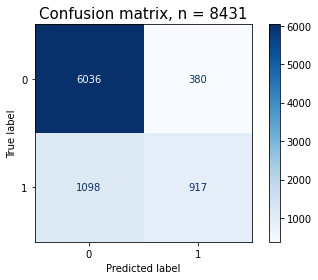

In [42]:
# confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# vacc_h1n1_f - 응답자가 H1N1 독감 백신을 받았는지 여부
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax)
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

False    7134
True     1297
dtype: int64

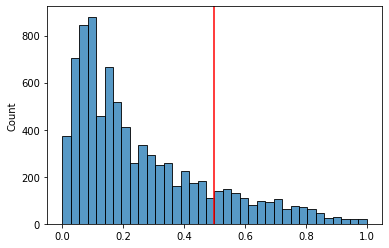

In [34]:
# predict_proba 함수는 각 샘플에 대해 어느 클래스에 속할 확률을 0에서 1 사이의 값으로 돌려준다.
# predict 함수는 새로운 속성들을 넣었을 때 그 클래스에 속하는지 속하지 않는지를 나타내는 1 또는 0으로 구성된 벡터를 반환
# predict 함수를 사용해 클래스의 레이블(정답에 해당하는 부분, 즉 매수 또는 매도)을 예측한다.

import seaborn as sns

threshold = 0.5
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [36]:
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.explore_threshold>

### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 하이퍼파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, oob_score=True
- **(Urclass Quiz) 확률값들의 분포의 변화를 아래 보기 중에서 고르세요**
    1. 다양해진다
    2. 변화가없다


In [82]:
### 이곳에서 과제를 진행해 주세요 ###
def mkpipe(i,threshold,X_train, y_train, X_val):
  xx=10  ** i
  pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=xx, random_state=10, n_jobs=-1,max_depth=None, oob_score=True))
  pipe.fit(X_train, y_train)
  y_pred_proba = pipe.predict_proba(X_val)[:, 1]
  y_pred = y_pred_proba > threshold
  ax = sns.histplot(y_pred_proba)
  ax.axvline(threshold, color='red')
  return accuracy_score(y_val, y_pred)

0.8244573597438026

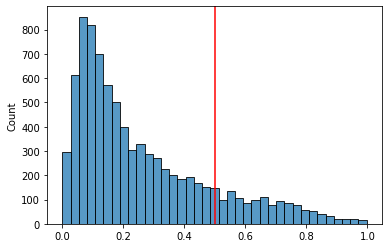

In [85]:
# n_estimators	- 결정트리의 갯수를 지정 - Default = 10 - 무작정 트리 갯수를 늘리면 성능 좋아지는 것 대비 시간이 걸릴 수 있음
# 1, 10, 100, 1000 > 10^(0, 1, 2, 3)

mkpipe(3,threshold,X_train, y_train, X_val)

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **(Urclass Quiz) 캐글 Leaderboard의 본인 Score를 제출하세요.**

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 

* 재현율: True Posirive Rate, TPR 
 - 실제 Positive인 것 중 올바르게 Positive를 맞춘 비율
* 위양성률: False Positive Rate, FPR
 - 실제 Negative인 것중 Positive로 잘못 맞춘 비율
* Threshold
 - TPR를 높이고자 Positive로 판단하는 임계값을 계속 낮추어 모두 Positive로 판단하게 만듬
  - 하지만 동시에 Negative이지만 Positive로 판단하는 위양성률도 같이 높아짐

**재현율은 최대화 하고 위양성률은 최소화 하는 임계값이 최적의 임계값**

In [60]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score,recall_score,f1_score
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score,roc_curve

False    7352
True     1079
dtype: int64

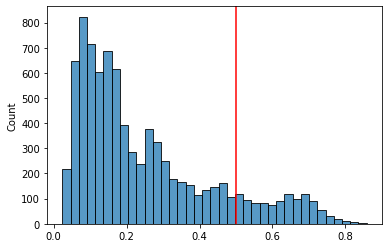

In [135]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=20, max_depth=10, oob_score=True, n_estimators=100)
)

pipe.fit(X_train, y_train)
# print('검증 정확도', pipe.score(X_val, y_val))
# y_pred = pipe.predict(X_val)
# print(classification_report(y_val, y_pred))

y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

0.8396087943911931

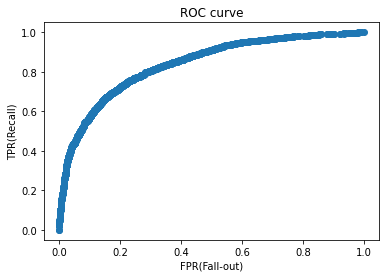

In [136]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

False    7367
True     1064
dtype: int64

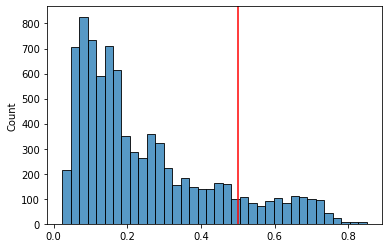

In [159]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=20, max_depth=10, oob_score=True, n_estimators=1000)
)

pipe.fit(X_train, y_train)
# print('검증 정확도', pipe.score(X_val, y_val))
# y_pred = pipe.predict(X_val)
# print(classification_report(y_val, y_pred))

y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()


0.8411515411223801

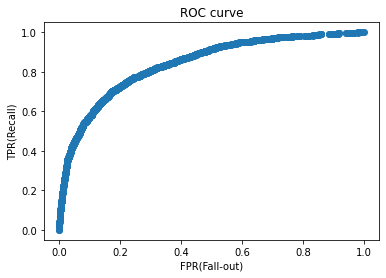

In [160]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

In [161]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 1263 , threshold: 0.2608565768508462


In [163]:
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype('int')

accuracy_score(y_val, y_pred_optimal)

0.7666943423081485

In [173]:
pred_proba = pipe.predict_proba(X_test)[:, 1]
pred = (pred_proba >= optimal_threshold).astype('int')
# submission data와 같은 형태를 만들어 주기 위해 데이터프레임으로 만듬
df_finall = pd.DataFrame(pred, columns=['vacc_h1n1_f'])
df_finall.shape

(28104, 1)

In [174]:
df_finall.to_csv('submission.csv', index_label='id', header=True)

## 🔥 도전과제(Github - Discussion)

### 5) confusion matrix, classification report 등을 그려 보시고, 각 평가지표들에 대해 최대한 분석하고 precision과 recall 중 어느 것을 높이는 방향으로 모델링 해야할지 논의해 보세요. 

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

False    7352
True     1079
dtype: int64

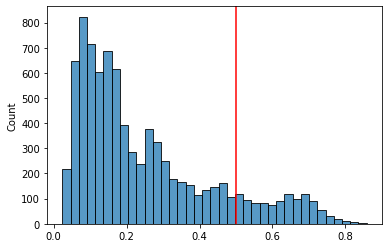

In [117]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=20, max_depth=10, n_estimators=100)
)

pipe.fit(X_train, y_train)
# print('검증 정확도', pipe.score(X_val, y_val))
# y_pred = pipe.predict(X_val)
# print(classification_report(y_val, y_pred))

y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

0.8396087943911931

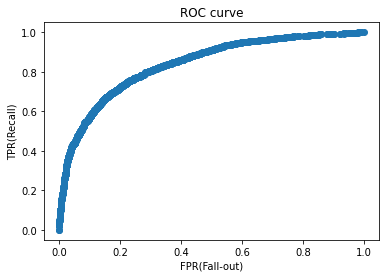

In [118]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

In [64]:
# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
# roc.sort_values(by='FPR(Fall-out)', ascending=0)

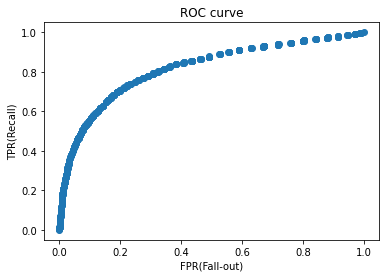

In [47]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

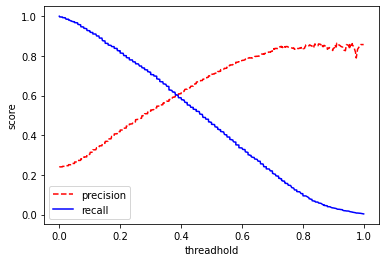

In [66]:
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
# precision,recall은 trade off관계, precision_recall_curve( )
precision,recall,th = precision_recall_curve(y_val,y_pred_proba)
plt.xlabel('threadhold') 
plt.ylabel('score')
plt.plot(th,precision[:len(th)],'red',linestyle = '--',label = 'precision')
plt.plot(th,recall[:len(th)],'blue',label = 'recall')
plt.legend()
plt.show()

idx: 342 , threshold: 0.3129166666666666


              precision    recall  f1-score   support

           0       0.90      0.81      0.85      6416
           1       0.54      0.70      0.61      2015

    accuracy                           0.78      8431
   macro avg       0.72      0.75      0.73      8431
weighted avg       0.81      0.78      0.79      8431



In [ ]:
# threshold = 0.31
threshold = optimal_threshold

y_pred_proba = pipe.predict_proba(X_val)[:, 1]
predicted = (y_pred_proba >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted)

# # 예측 확률
# proba= model.predict_proba(X_test)

fpr,tpr,th = roc_curve(y_test,proba[:,1])
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)


y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()



In [57]:


# 예측 확률
proba= model.predict_proba(X_test)

predicted_proba = random_forest.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted)

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)
# RandomForestClassifier(n_jobs=-1, random_state=10, max_depth=None, oob_score=True, n_estimators=100)

pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))



검증 정확도 0.8246945795279327
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      6416
           1       0.71      0.46      0.55      2015

    accuracy                           0.82      8431
   macro avg       0.78      0.70      0.72      8431
weighted avg       0.81      0.82      0.81      8431



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


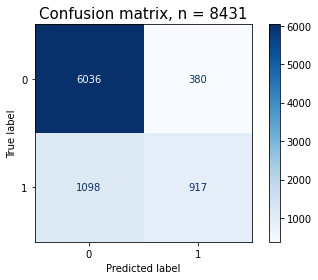

In [58]:
# vacc_h1n1_f - 응답자가 H1N1 독감 백신을 받았는지 여부
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax)
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

False    7134
True     1297
dtype: int64

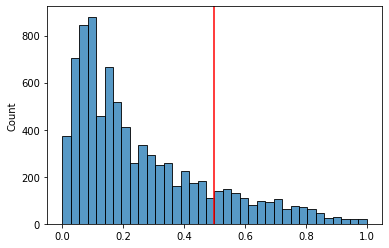

In [59]:

y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [38]:
# 실제 타겟 값과 예측확률을 데이터프레임의 예측 확률 낮은 순
pred_proba = pd.DataFrame({
    'y_val': y_val,
    'pred_proba': y_pred_proba})
top = pred_proba.sort_values(by='pred_proba', ascending=True)[:4500]
top

,y_val,pred_proba
4001,0,0.0
26391,0,0.0
12630,0,0.0
29981,1,0.0
3005,0,0.0
...,...,...
14830,0,0.2
10106,0,0.2
18998,0,0.2
26789,0,0.2
